In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import sklearn
import numpy as np
import random
import matplotlib.pyplot as plt

C:\Users\JW\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


Original df shape:  (1460, 80)
Any NaN in target:  False
df shape after dropping NaN columns:  (1460, 75)


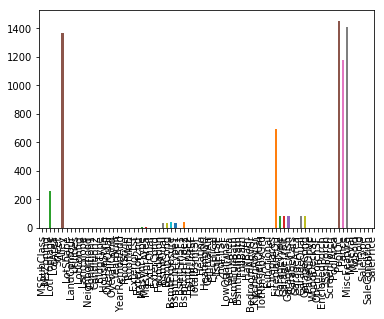

In [42]:
# Source & Data: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
# Define random seeds
np.random.seed(10)
random.seed(10)

path = "D:/git/House_price_predictor/"
df = pd.read_csv(os.path.join(path, 'train.csv'))
Id = df.pop('Id') # Remove the Id column
print('Original df shape: ', df.shape)
print('Any NaN in target: ', df['SalePrice'].isnull().values.any()) # Check if the target column has NaN
# Count the number of NaN in each column
na_count = df.isnull().sum()
# Visualize the count of NaN
na_count.plot.bar()
# Drop the columns with more than one third of NaN numbers
na_msk = na_count < df.shape[0]/3
df = df.loc[:,na_msk]
print('df shape after dropping NaN columns: ', df.shape)

(1460, 75)


pandas.core.series.Series

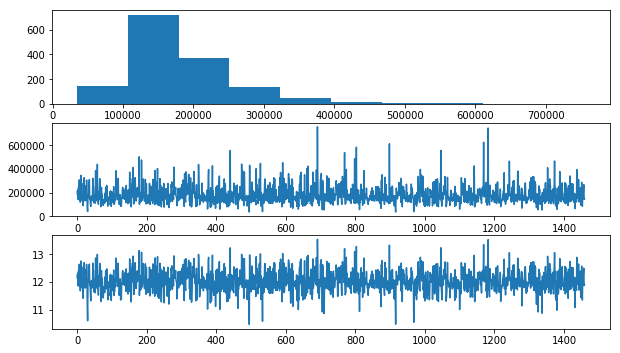

In [43]:
# Visualize the sale price
fig = plt.figure(figsize=(10,10))
num_rows = 5
ax1 = fig.add_subplot(num_rows,1,1)
ax2 = fig.add_subplot(num_rows,1,2)
ax3 = fig.add_subplot(num_rows,1,3)
print(df.shape)
log_price = np.log(df.SalePrice)

ax1.hist(df.SalePrice)
ax2.plot(df.SalePrice)
ax3.plot(log_price)

type(log_price)

In [44]:
### Find columns with non-digital element (object)
msk = df.dtypes == 'object'
colums_to_encode = df.loc[:,msk].columns.tolist()
# One hot encoding
df_encoded = pd.get_dummies(df, colums_to_encode)
print('df shape after one-hot encoding: ', df_encoded.shape)

df shape after one-hot encoding:  (1460, 271)


In [45]:
# Train test split
df_target = df_encoded.pop('SalePrice')

df_train, df_test, df_train_target, df_test_target = train_test_split(df_encoded, df_target, test_size=0.2)
df_train, df_val, df_train_target, df_val_target = train_test_split(df_train, df_train_target, test_size=0.25)

In [48]:
X_train, y_train = df_train.values, df_train_target.values
X_val, y_val = df_val.values, df_val_target.values
X_test, y_test = df_test.values, df_test_target.values

print('Train set size: ', X_train.shape)
print('Validation set size: ', X_val.shape)
print('Test set size: ', X_test.shape)

Train set size:  (876, 270)
Validation set size:  (292, 270)
Test set size:  (292, 270)


In [49]:
# Purify the data/ Handle NaN
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
X_train = my_imputer.fit_transform(X_train)
X_val = my_imputer.transform(X_val)
X_test = my_imputer.transform(X_test)

In [50]:
def my_mape_obj(preds, dmatrix):
    # Positive error: preds[i] >= labels[i]
    # Negative error: preds[i] < labels[i]
    # Loss funtion: J = 1/N * sum(sign(preds-labels)/lebel)
    labels = dmatrix.get_label()
    beta = 100.0
    # Define a "bias mask" which gives larger weight for Negative errors (preds[i] < labels[i]).
    msk_bias = [1.0/beta if preds[i]-labels[i] >= 0 else beta for i in range(len(labels))]
    # grad and hess should not be too small. Otherwise cannot train.
    grad = -100.0*np.multiply(msk_bias,(labels-preds))/labels
    hess = 100.0/labels
    return grad, hess

def my_err_rate(y_hat, dtrain):
    y = dtrain.get_label()
    y_hat = np.clip(y_hat, 10e-7, 1-10e-7)
    loss_fn = y*np.log(y_hat)
    loss_fp = (1.0 - y)*np.log(1.0 - y_hat)
    return 'myloss', np.sum(-(5*loss_fn+loss_fp))/len(y), False

def mape(preds, labels):
    error = sum(abs(preds-labels)*1.0/(labels))*1.0/len(labels)
    return error

In [51]:
###### LightGBM ############
import lightgbm as lgb

weights_train = 1 + (df_train['YrSold'] - 2010) * 0.2
d_train = lgb.Dataset(X_train, label=y_train, weight=weights_train)
weights_val = 1 + (df_val['YrSold'] - 2010) * 0.2
d_val = lgb.Dataset(X_val, label=y_val, weight=weights_val)
# watchlist = [(dval, 'eval'), (dtrain, 'train')]

params = {'learning_rate': 0.01,
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'mae'}

params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

bst = lgb.train(params=params, 
                train_set=d_train, 
                num_boost_round=1000, 
                valid_sets=[d_val],
                fobj=my_mape_obj,
                feval=None,
                early_stopping_rounds=5,
                verbose_eval=False
               )

Mean Absolute Error:  29521.6285547
Mean Absolute Percentage Error:  0.197368236964


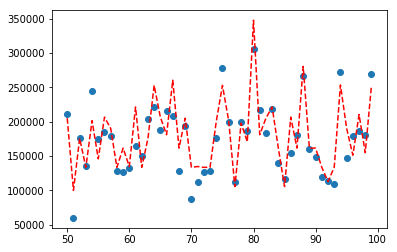

In [52]:
# Visualize the data and predictions
from sklearn.metrics import mean_absolute_error

predictions = bst.predict(X_test)

print("Mean Absolute Error: ", mean_absolute_error(predictions, y_test))
print("Mean Absolute Percentage Error: ", mape(predictions, y_test))
num_to_plot = 100
Id_test = np.arange(len(y_test))
plt.scatter(Id_test[50:num_to_plot], y_test[50:num_to_plot])
plt.plot(Id_test[50:num_to_plot], predictions[50:num_to_plot], c='r', ls='--')

In [53]:
# Generate house data which was sold in 2010
df_test = pd.DataFrame(X_test, columns=df_encoded.columns.values)
msk_2010 = df_test.YrSold == 2010
predictions_2010 = predictions[msk_2010]
y_test_2010 = y_test[msk_2010]
# Generate house data which was sold in 2006
msk_2006 = df_test.YrSold == 2006
predictions_2006 = predictions[msk_2006]
y_test_2006 = y_test[msk_2006]

Mean Absolute Percentage Error (2006):  0.192652695326


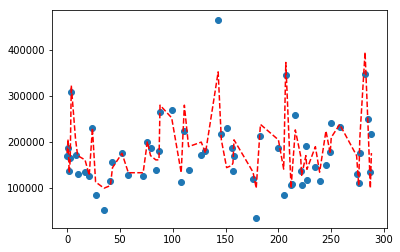

In [54]:
# Visualize house data and predictions for 2006
Id_2006 = Id_test[msk_2006]
plt.scatter(Id_2006, y_test_2006)
plt.plot(Id_2006, predictions_2006, c='r', ls='--')
print("Mean Absolute Percentage Error (2006): ", mape(predictions_2006, y_test_2006))

Mean Absolute Percentage Error (2010):  0.152971591537


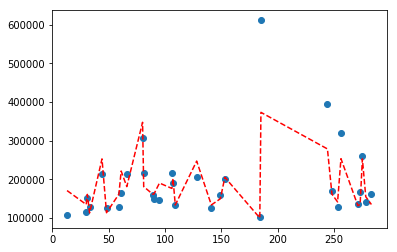

In [55]:
# Visualize house data and predictions for 2010
Id_2010 = Id_test[msk_2010]
plt.scatter(Id_2010, y_test_2010)
plt.plot(Id_2010, predictions_2010, c='r', ls='--')
print("Mean Absolute Percentage Error (2010): ", mape(predictions_2010, y_test_2010))

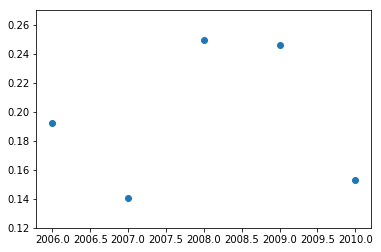

In [56]:
# Calculate mape for individual years
union_yr = list(set(df_test.YrSold.values))
union_yr.sort
mape_yr = []
for yr in union_yr:
    msk_yr = df_test.YrSold == yr
    mape_yr.append(mape(predictions[msk_yr], y_test[msk_yr]))

plt.scatter(union_yr, mape_yr)